In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
device = torch.device('cpu')  # Usamos CPU para este ejemplo

## Funciones a utilizar

In [2]:
# Function to compute derivatives
def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for i in range(order):
        dy = torch.autograd.grad(
            dy, x, grad_outputs=torch.ones_like(dy), create_graph=True, retain_graph=True
        )[0]
    return dy

In [3]:
def Legendre(x: torch.Tensor, n: int) -> torch.Tensor:

    # Inicializa los dos primeros polinomios de Legendre
    legendre_polynomials = [torch.ones_like(x), x]

    # Calcula los polinomios de Legendre hasta el grado n
    for _ in range(2, n):
        # Coeficientes para la relación de recurrencia de los polinomios de Legendre
        a = (2 * _ - 1) / _
        b = (_ - 1) / _

        # Calcula el polinomio de Legendre de grado i usando la relación de recurrencia
        legendre_polynomial = a * x * legendre_polynomials[-1] - b * legendre_polynomials[-2]

        # Añade el polinomio de Legendre de grado i a la lista
        legendre_polynomials.append(legendre_polynomial)

    # Devuelve los polinomios de Legendre como un tensor de PyTorch
    return torch.stack(legendre_polynomials, dim=1)

class OrthogonalNeuralNetwork(nn.Module):
    
    def __init__(self, n: int, lb: float, ub: float):
        super(OrthogonalNeuralNetwork, self).__init__()
        self.n = n
        self.lb = lb
        self.ub = ub
        
        # Inicializa los coeficientes como parámetros del modelo que se aprenderán durante el entrenamiento
        self.weights = torch.nn.Parameter(torch.zeros(n, dtype=torch.float64))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Normaliza la entrada
        x = 2 * (x - self.lb) / (self.ub - self.lb) - 1

        # Calcula los polinomios de Legendre hasta el grado especificado
        legendre_polynomials = Legendre(x, self.n)

        # Realiza una combinación lineal de los polinomios de Legendre seleccionados utilizando los coeficientes aprendidos
        return torch.matmul(legendre_polynomials, self.weights) 

In [4]:
lb = 1  
ub = 2
x = torch.linspace(lb, ub, 10, dtype=torch.float64, requires_grad=True).to(device)
model = OrthogonalNeuralNetwork(5, lb, ub).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'El modelo tiene {num_params} parámetros.')

# Definir la función de pérdida y el optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(),
                                lr=0.1,
                                max_iter=10_000,
                                max_eval=10_000,
                                tolerance_grad=1e-6,
                                history_size=50,
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn=None)
 

# Definir la función de cierre
iter_count=0
def closure():
    global iter_count
    iter_count+=1
    optimizer.zero_grad()
    y_pred = model(x) 
    y_t = 2/3 + x/3 + (x-1)*(x-2)*y_pred  
    y_xx = derivative(y_t, x, order=2)
    residuo = ((y_t**3 - 2*y_t**2)/(2*x**2)) - y_xx  
    loss = criterion(residuo,torch.zeros_like(residuo))
    #if iter_count % 100 == 0: 
    #    print(f'iter {iter_count}, loss: {loss.detach().numpy()}')
    loss.backward(retain_graph=True)
    return loss

# Función para entrenar el modelo
def train_model():
    start_time = time.time()
    #for epoch in range(epochs):
    optimizer.step(closure)
    end_time = time.time()
    y_pred = model(x) 
    y_t = 2/3 + x/3 + (x-1)*(x-2)*y_pred  
    y_xx = derivative(y_t, x, order=2)
    residuo = ((y_t**3 - 2*y_t**2)/(2*x**2)) - y_xx  
    loss = criterion(residuo,torch.zeros_like(residuo))    
    print(f'Final loss: {loss.detach().numpy()}')
    print(f'Tiempo de entrenamiento: {end_time - start_time} segundos')

# Entrenar el modelo
train_model()

El modelo tiene 5 parámetros.
Final loss: 8.715186685362638e-09
Tiempo de entrenamiento: 0.4304664134979248 segundos


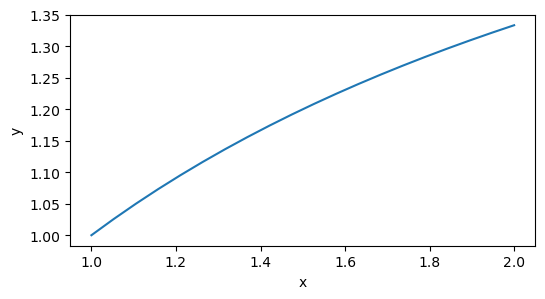

In [5]:
x = torch.linspace(lb, ub, 20, dtype=torch.float64, requires_grad=True).to(device)
with torch.no_grad():
    y_pred = model(x)
y_pred = 2/3 + x/3 + (x-1)*(x-2)*y_pred  
# Convertir tensores a numpy para visualización
x = x.cpu().detach().numpy()
y_pred = y_pred.cpu().detach().numpy()

# Graficar los resultados
plt.figure(figsize=(6, 3))
plt.plot(x, y_pred)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()

In [6]:
# Define input x with double precision
x = torch.tensor([1.1320], dtype=torch.float64)

# Ensure prediction y_pred also uses double precision
with torch.no_grad():
    y_pred = model(x)

# Perform the computation with double precision
y_pred = 2/3 + x/3 + (x-1)*(x-2)*y_pred

# Print the result
print(np.round(y_pred.item(), 4))

1.0619
